In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# function to generate data
def generate_data(N, T, rho, sigma, q, seed=0):
  mu = np.zeros((N,T))

  np.random.seed(seed)
  # generate mu_1 from the stationary distribution
  n_step = np.random.geometric(rho,N) - 1
  mu[:,0] = np.random.binomial(n_step,q)*2 - n_step

  # for each t>=2, generate mu_t from the Markov chain
  for t in np.arange(1,T):
    B_step = np.random.binomial(1,q,N)*2 - 1
    B_renew = np.random.binomial(1,rho,N)
    mu[:,t] = (mu[:,t-1] + B_step) * (1-B_renew)

  # add Gaussian noise
  return mu + sigma * np.random.normal(size=(N,T))



In [3]:
# generate data for varying values of rho

X_seed = 12345
Y_seed = 54321

N = 10000
T = 100
sigma = 1
q = 0.75

rho_list = [0.01, 0.05, 0.1, 0.5]
nrho = len(rho_list)

X = np.zeros((N,T,nrho))
Y = np.zeros((N,T,nrho))
for irho in np.arange(nrho):
  X[:,:,irho] = generate_data(N,T,rho_list[irho],sigma,q,X_seed)
  Y[:,:,irho] = generate_data(N,T,rho_list[irho],sigma,q,Y_seed)

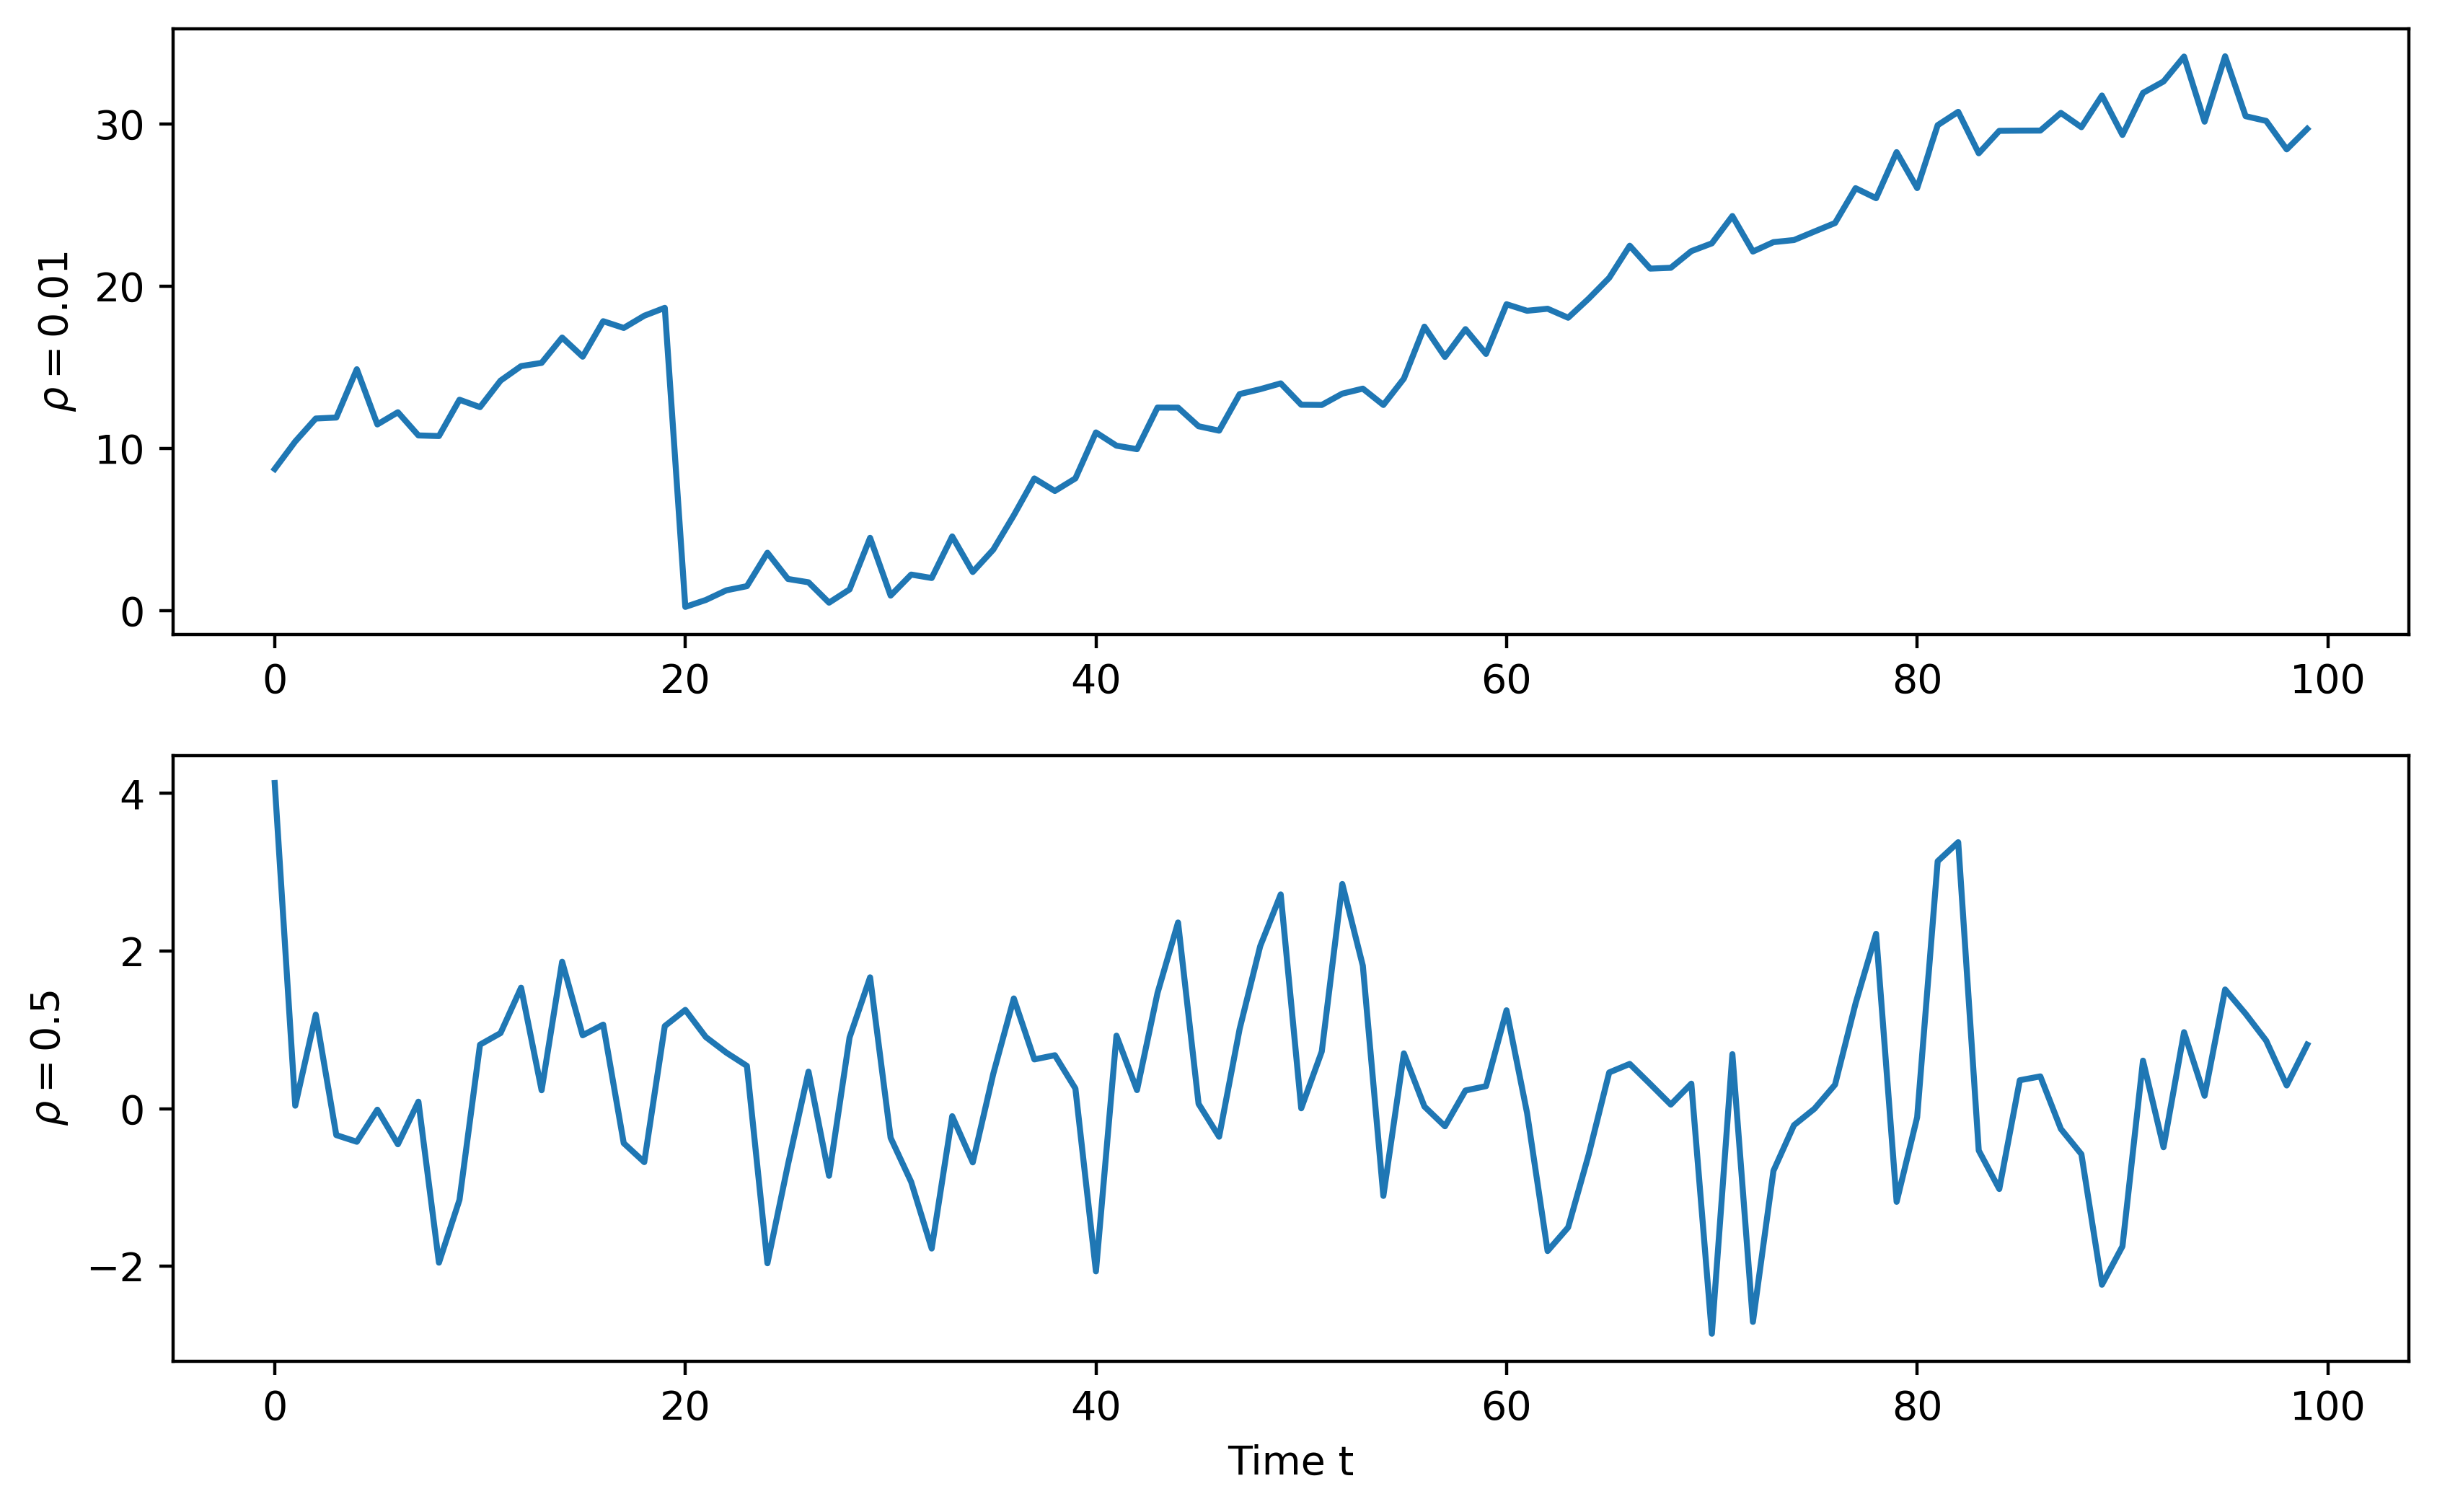

In [4]:
# visualize data

_, (ax1,ax2) = plt.subplots(2,1,figsize=(10,6),dpi=400)

ax1.plot(np.arange(T),X[2,:,0])
ax1.set_ylabel(fr"$\rho={rho_list[0]}$")
ax2.plot(np.arange(T),X[0,:,3])
ax2.set_ylabel(fr"$\rho={rho_list[3]}$")
ax2.set_xlabel('Time t')

plt.show()

In [5]:
# function computing p-value for detecting events
def event_detection(X, Y, t):
    N = X.shape[0]
    T = X.shape[1]
    p_vals = np.zeros(N)
    for i in np.arange(N):
        Psi_matrix = np.add.outer(X[i],Y[i])
        p_vals[i] = np.sum(Psi_matrix >= Psi_matrix[t,t]) / (T**2)
    return p_vals

# function computing p-value for detecting synchronicity
def sync_detection(X, Y, w_param, inflate_eps=0):
    N = X.shape[0]
    T = X.shape[1]

    X2 = np.concatenate([X, X], axis=1)
    Y2 = np.concatenate([Y, Y], axis=1)

    sum_vec = np.zeros(T)
    sum_vec[:(w_param-1)] = (-1)**np.arange(w_param-1) * (-1)
    sum_vec[-1] = 1

    p_vals = np.zeros(N)

    psi = np.zeros((N,T,T))
    for k in np.arange(T):
      for l in np.arange(T):
        psi[:,k,l] = 1/w_param * ((X2[:,k:(k+T)].dot(sum_vec))**2\
                                  + (Y2[:,k:(k+T)].dot(sum_vec))**2)

    p_vals = (psi.reshape((N,-1)) + inflate_eps >= np.outer(psi[:,0,0],\
                           np.ones(T**2))).sum(axis=1) / (T**2)
    return p_vals

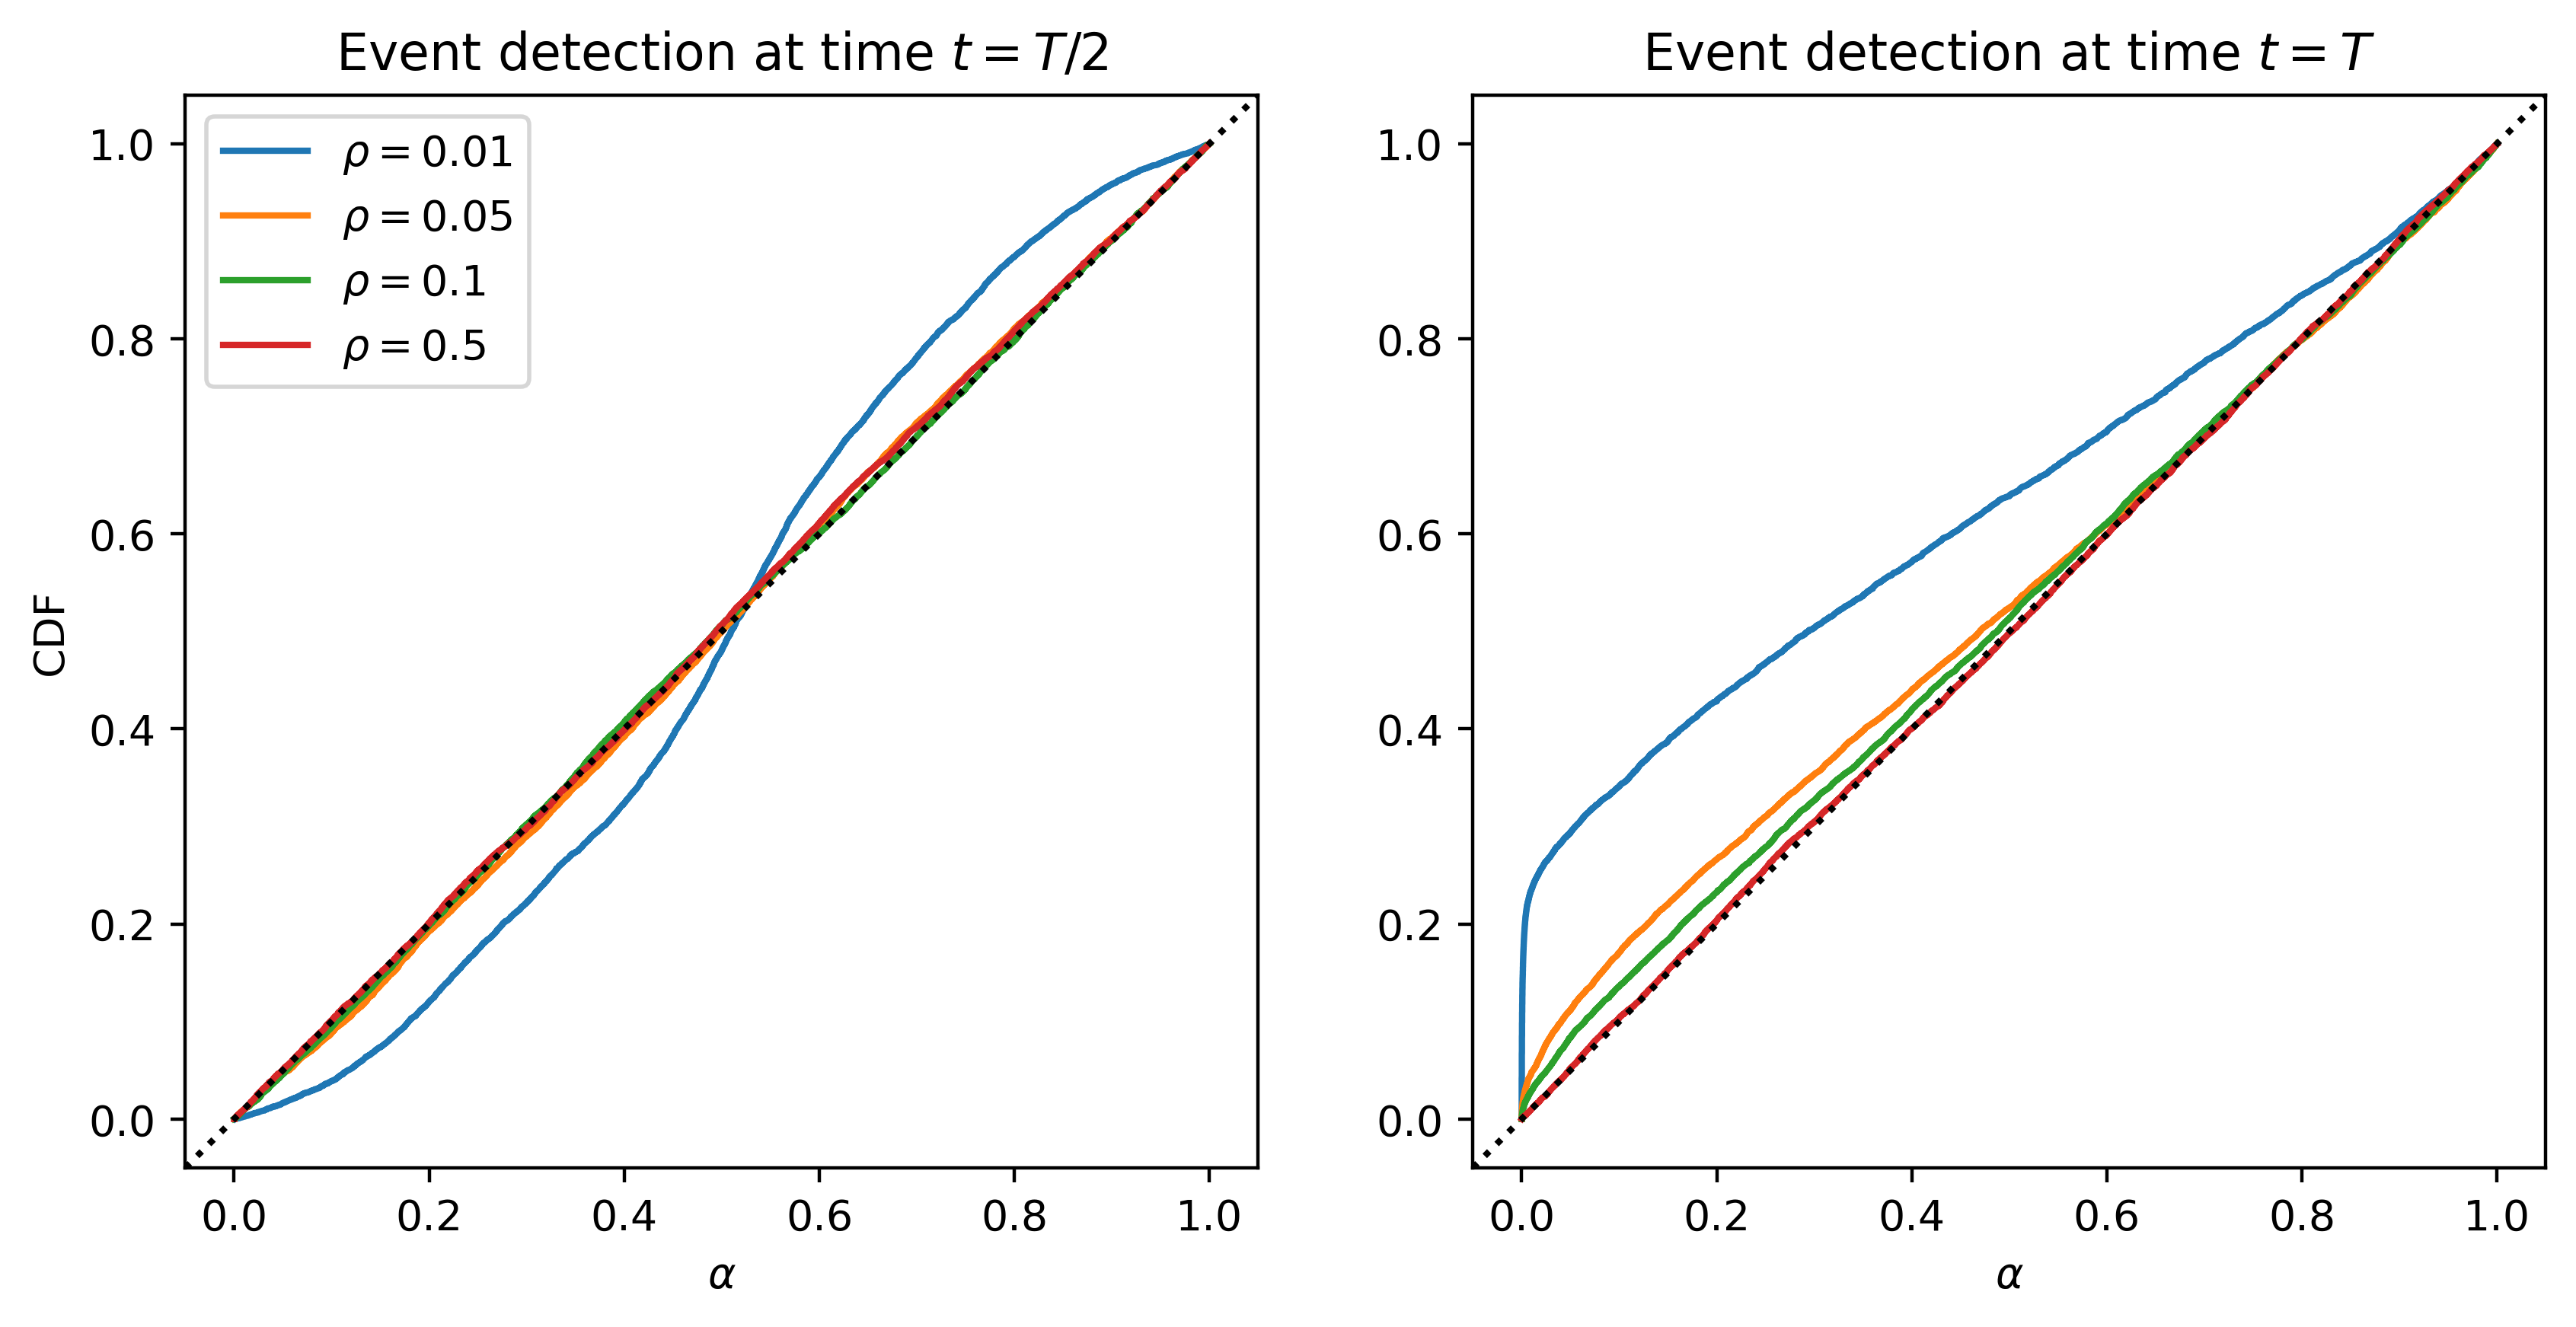

In [6]:
# run simulation for detecting events

p_vals_event = np.zeros((N,2,nrho))
for irho in np.arange(nrho):
  p_vals_event[:,0,irho] = event_detection(X[:,:,irho],Y[:,:,irho],T//2-1)
  p_vals_event[:,1,irho] = event_detection(X[:,:,irho],Y[:,:,irho],T-1)

# plot results for detecting events

_, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5),dpi=400)

for irho in np.arange(nrho):
  cdf_grid = np.arange(1,N+1)/(N+1)
  ax1.plot(np.sort(p_vals_event[:,0,irho]),cdf_grid,label=fr"$\rho={rho_list[irho]}$")
  ax2.plot(np.sort(p_vals_event[:,1,irho]),cdf_grid,label=fr"$\rho={rho_list[irho]}$")

ax1.axline((0,0), slope=1, linestyle='dotted', color='black')
ax2.axline((0,0), slope=1, linestyle='dotted', color='black')

ax1.set_xlabel(r"$\alpha$")
ax2.set_xlabel(r"$\alpha$")
ax1.set_ylabel("CDF")

ax1.set_title("Event detection at time $t=T/2$")
ax2.set_title("Event detection at time $t=T$")

ax1.legend()

ax1.set_box_aspect(aspect=1)
ax2.set_box_aspect(aspect=1)
plt.show()

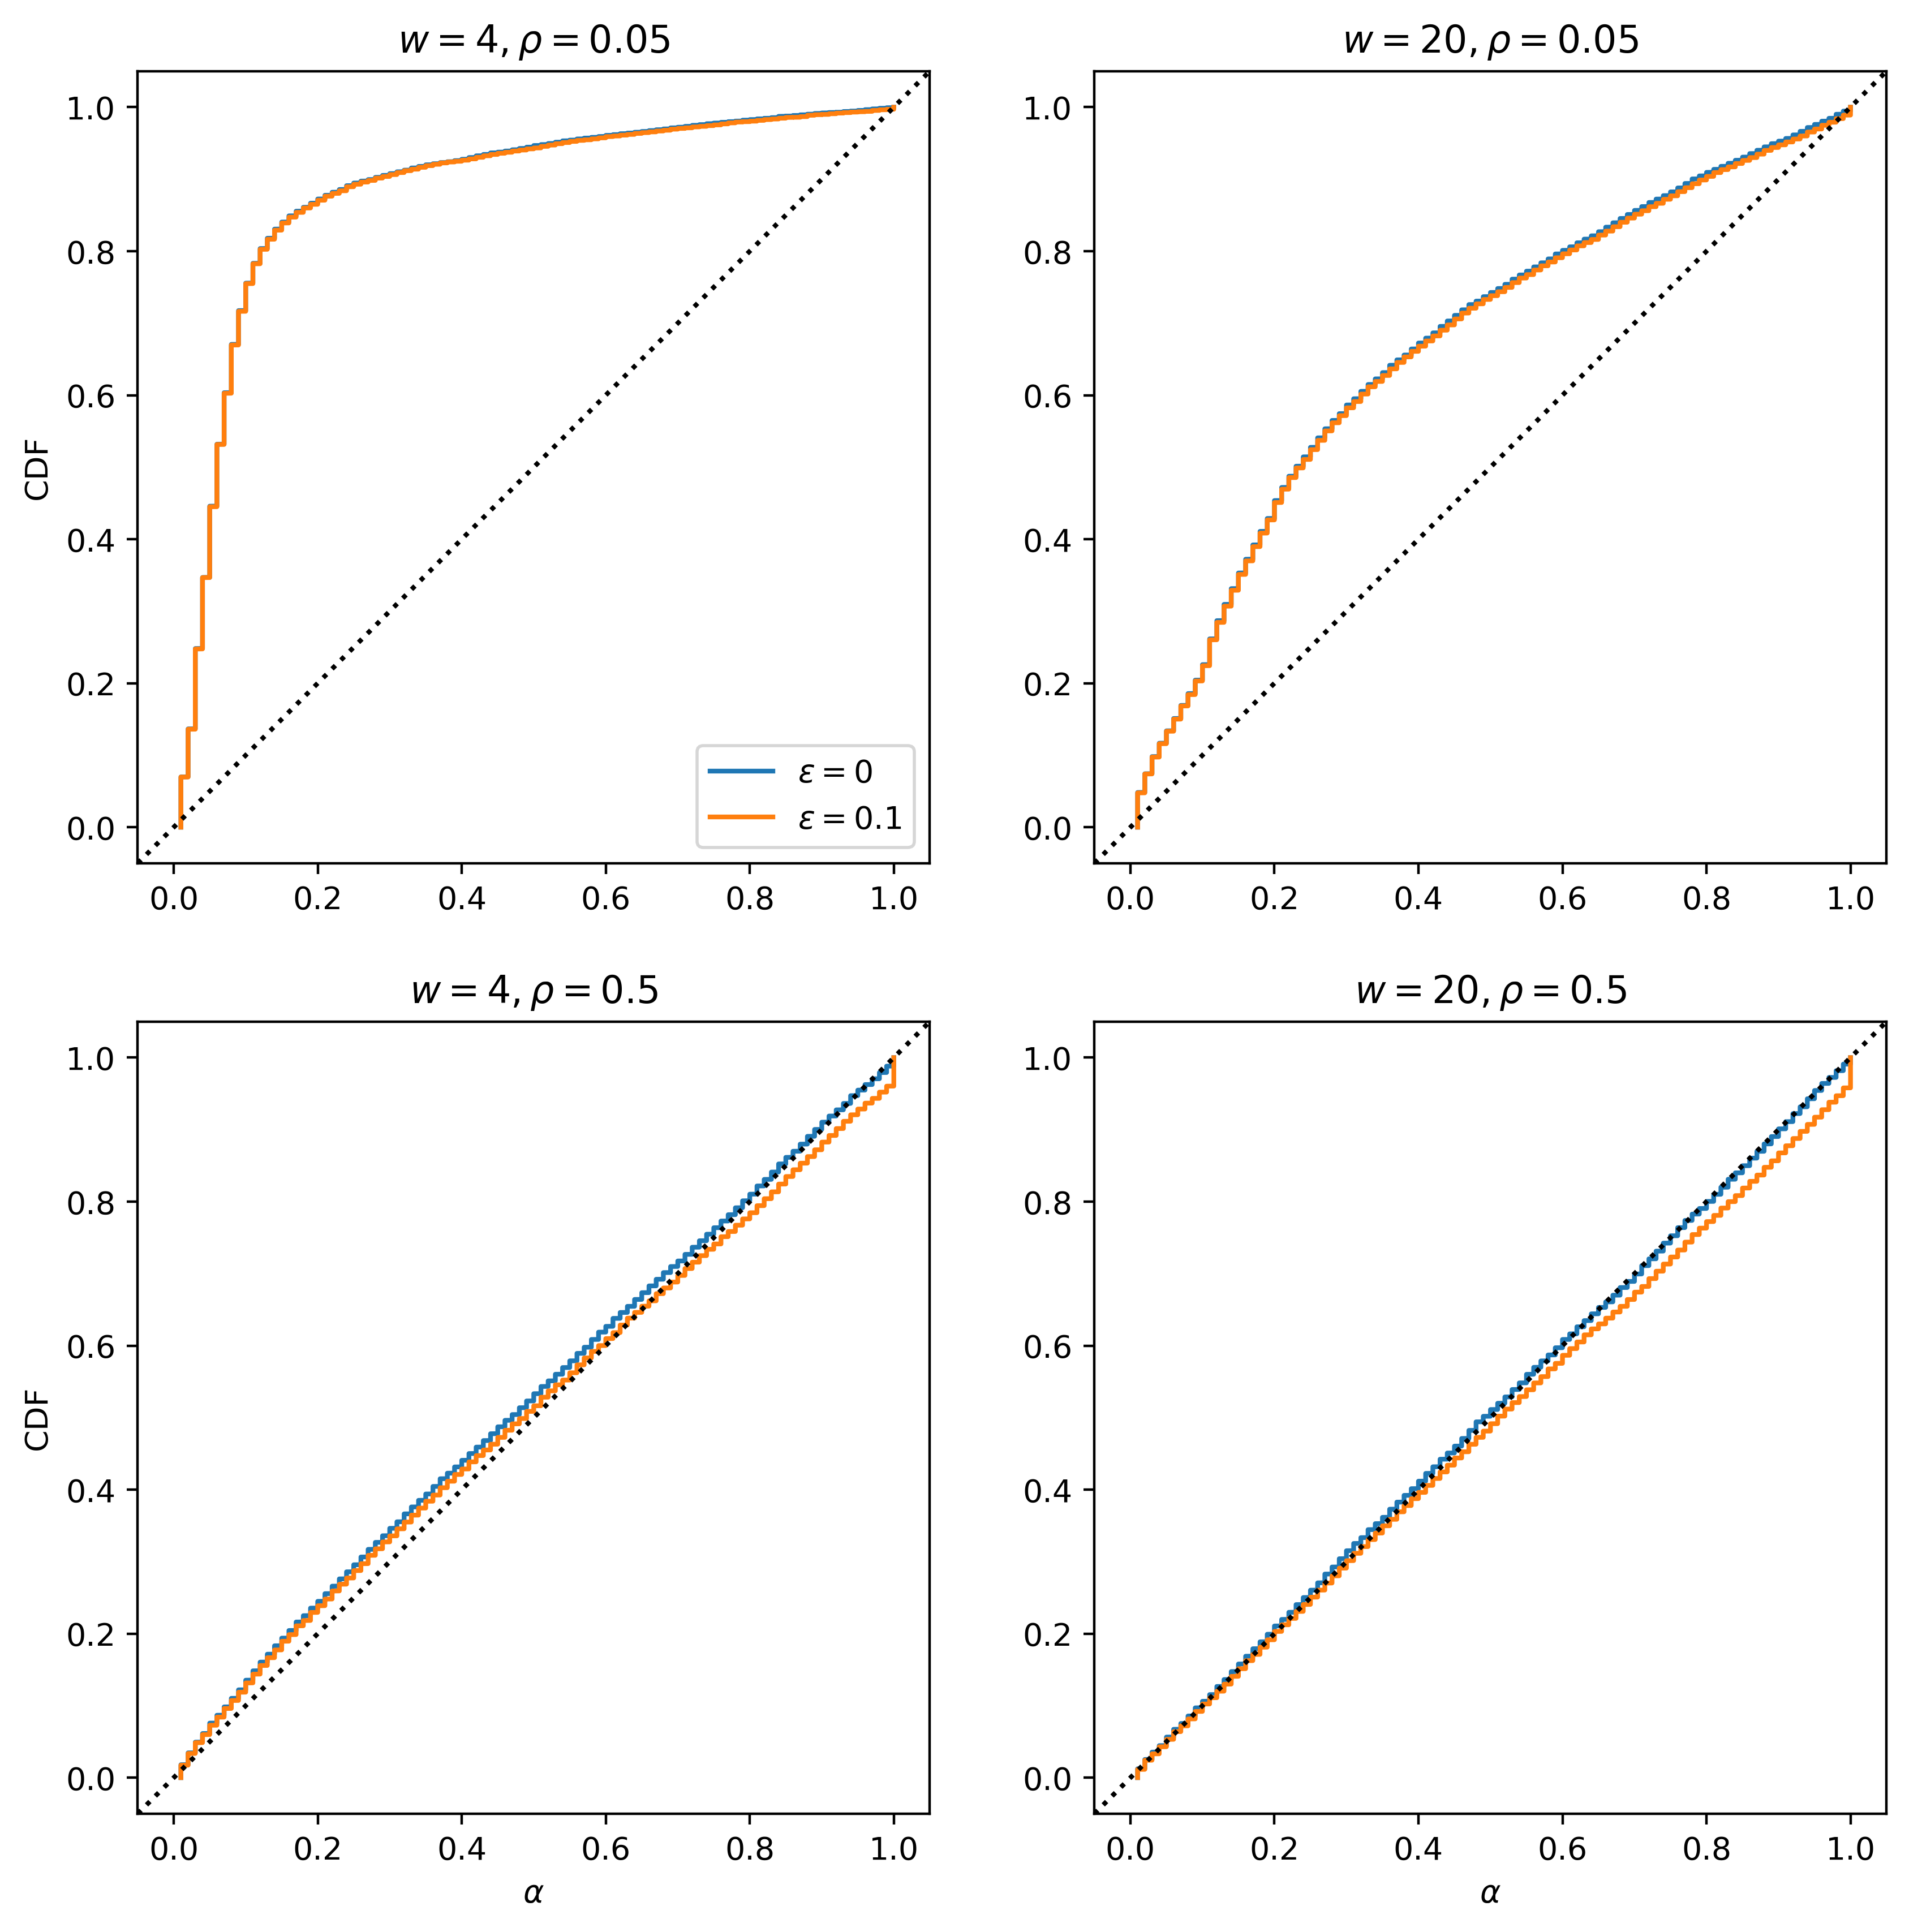

In [7]:
# run simulation for detecting synchronicity

w_params = [4,20]
n_w = len(w_params)

eps_list = [0,0.1]
n_eps = len(eps_list)

rho_ind_list = [1,3]
nrho_ind = len(rho_ind_list)


p_vals_sync = np.zeros((N,nrho_ind,n_w,n_eps))
for irho_ind in np.arange(nrho_ind):
  for i_w in np.arange(n_w):
    for i_eps in np.arange(n_eps):
      irho = rho_ind_list[irho_ind]
      p_vals_sync[:,irho_ind,i_w,i_eps] = sync_detection(X[:,:,irho],Y[:,:,irho],w_params[i_w],eps_list[i_eps])


# plot results for detecting synchronicity

_, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(10,10),dpi=400)

for i_eps in np.arange(n_eps):
  cdf_grid = np.arange(1,N+1)/(N+1)
  ax1.plot(np.sort(p_vals_sync[:,0,0,i_eps]),cdf_grid,label=fr"$\varepsilon={eps_list[i_eps]}$")
  ax2.plot(np.sort(p_vals_sync[:,0,1,i_eps]),cdf_grid,label=fr"$\varepsilon={eps_list[i_eps]}$")
  ax3.plot(np.sort(p_vals_sync[:,1,0,i_eps]),cdf_grid,label=fr"$\varepsilon={eps_list[i_eps]}$")
  ax4.plot(np.sort(p_vals_sync[:,1,1,i_eps]),cdf_grid,label=fr"$\varepsilon={eps_list[i_eps]}$")

ax1.axline((0,0), slope=1, linestyle='dotted', color='black')
ax2.axline((0,0), slope=1, linestyle='dotted', color='black')
ax3.axline((0,0), slope=1, linestyle='dotted', color='black')
ax4.axline((0,0), slope=1, linestyle='dotted', color='black')

ax3.set_xlabel(r"$\alpha$")
ax4.set_xlabel(r"$\alpha$")

ax1.set_title(fr"$w={w_params[0]},\rho={rho_list[rho_ind_list[0]]}$")
ax2.set_title(fr"$w={w_params[1]},\rho={rho_list[rho_ind_list[0]]}$")
ax3.set_title(fr"$w={w_params[0]},\rho={rho_list[rho_ind_list[1]]}$")
ax4.set_title(fr"$w={w_params[1]},\rho={rho_list[rho_ind_list[1]]}$")

ax1.set_ylabel("CDF")
ax3.set_ylabel("CDF")

ax1.legend()

ax1.set_box_aspect(aspect=1)
ax2.set_box_aspect(aspect=1)
ax3.set_box_aspect(aspect=1)
ax4.set_box_aspect(aspect=1)
plt.show()